In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt

import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tqdm import tqdm
from keras import regularizers

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Working with the meta data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/training_set_pixel_size_and_HC.csv')
df.head()

,filename,pixel size(mm),head circumference (mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81


In [ ]:
df["img_path"] = '/content/drive/MyDrive/training_set/' + df['filename']
df.head()

,filename,pixel size(mm),head circumference (mm),img_path
0,000_HC.png,0.069136,44.30,/content/drive/MyDrive/training_set/000_HC.png
1,001_HC.png,0.089659,56.81,/content/drive/MyDrive/training_set/001_HC.png
2,002_HC.png,0.062033,68.75,/content/drive/MyDrive/training_set/002_HC.png
3,003_HC.png,0.091291,69.00,/content/drive/MyDrive/training_set/003_HC.png
4,004_HC.png,0.061240,59.81,/content/drive/MyDrive/training_set/004_HC.png


In [ ]:
def preprocess_images(image_paths, target_size=(512, 512)):
    images = []
    for path in tqdm(image_paths, desc='Processing images'):
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

In [ ]:
image_paths = [filename for filename in df['img_path']]
preprocessed_images = preprocess_images(image_paths)

Processing images: 100%|██████████| 999/999 [00:18<00:00, 54.04it/s]


In [ ]:
preprocessed_images.shape

(999, 512, 512, 3)

In [ ]:
min_pixel_value = np.min(preprocessed_images)
max_pixel_value = np.max(preprocessed_images)

print(f"Minimum Pixel Value: {min_pixel_value}")
print(f"Maximum Pixel Value: {max_pixel_value}")


Minimum Pixel Value: 0.0
Maximum Pixel Value: 254.0


The number of pixels varies from 0 to 254


In [ ]:
# Normalization

preprocessed_images = preprocessed_images / 255.0

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(preprocessed_images, np.array(df['head circumference (mm)']), test_size=0.2, random_state=42)


In [ ]:
def vgg16(input_shape, top='flatten'):
    if top not in ('flatten', 'avg', 'max'):
        raise ValueError('unexpected top layer type: %s' % top)
    print('The model is VGG16.')
    #base = VGG16(input_shape=input_shape, include_top=False)#train from scratch
    base = VGG16(weights='imagenet', input_shape=input_shape, include_top=False)
    x = base.output
    x = GlobalAveragePooling2D()(x) # Flatten | GlobalAveragePooling2D | GlobalMaxPooling2D
    x = Dropout(0.7)(x)
    x = Dense(512,kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01))(x)
    x = Dense(256, kernel_regularizer=regularizers.l2(0.01),
              activity_regularizer=regularizers.l1(0.01))(x)
    x = Dense(128, kernel_regularizer=regularizers.l2(0.01),
              activity_regularizer=regularizers.l1(0.01))(x)
    x = Dense(64, kernel_regularizer=regularizers.l2(0.01),
              activity_regularizer=regularizers.l1(0.01))(x)
    x = Dense(32, kernel_regularizer=regularizers.l2(0.01),
              activity_regularizer=regularizers.l1(0.01))(x)
    pred = Dense(1, activation='linear')(x)
    model = Model(inputs=base.inputs, outputs=pred)

    '''
    Classif
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.7)(x)
    predictions = Dense(num_classes, activation= 'softmax')(x)
    model = Model(inputs = base.input, outputs = predictions)
    '''
    return model

In [ ]:
model = vgg16((512,512,3), top = 'flatten')

The model is VGG16.


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     

In [ ]:
model.compile(optimizer=Adam(learning_rate = 0.0001), loss='mean_squared_error', metrics=['mae'])


In [ ]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_model_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(patience=10, monitor='val_loss', mode='min', verbose=1)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/100


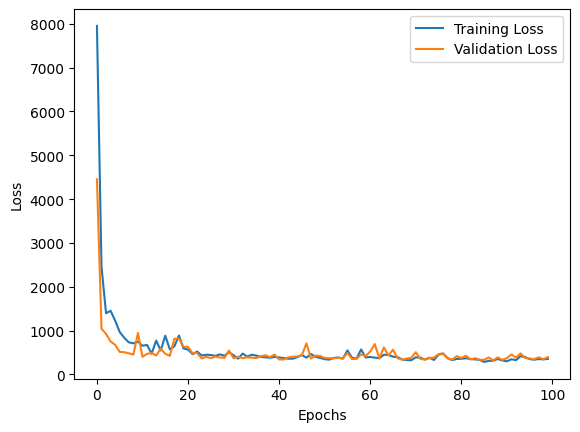

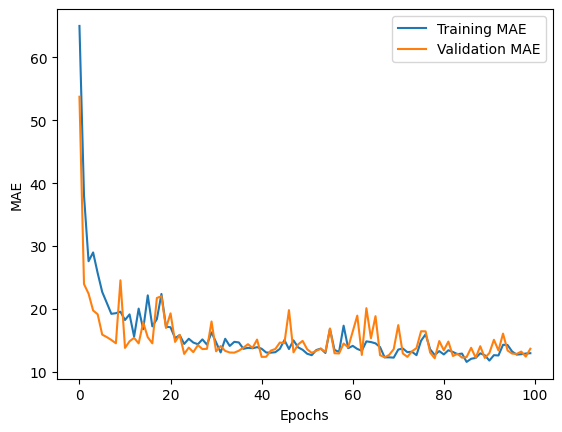

In [ ]:
# Save training history plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/training_history_loss.png')
plt.show()

# Save MAE plot
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.savefig('/content/drive/MyDrive/training_history_mae.png')
plt.show()

In [ ]:
y_train

778    189.40
286    155.95
165     99.40
960    300.40
493    168.35
        ...  
106     79.09
270    171.80
860    259.30
435    180.47
102     82.58
Name: head circumference (mm), Length: 799, dtype: float64